Code to verify that modified version of the PH manager adopted from the GINN repo works 

In [ ]:

import os
import sys
# To allow me to import the functiosn from other folders from the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
import numpy as np
import matplotlib.pyplot as  plt
from pathlib import Path
from torchsummary import summary
import time
import torch.nn as nn
from scipy.interpolate import griddata
from tqdm import trange
from torch.autograd import grad, Variable
from torch.utils.data import Dataset, DataLoader,TensorDataset
from tabulate import tabulate

from Functions.Point_Sampling.point_sampler import Point_Sampler
from Test_Cases.Bridge_around_object.BRIDGE_Master_object import BRIDGE_Master_Object

BRIDGE = BRIDGE_Master_Object(Normalize=True,Symmetry=False)
BRIDGE.create_interfaces() 

from File_Paths.file_paths import interfaces_path, mesh_path
from Functions.Point_Sampling.point_sampler import Point_Sampler

import os
import math
import random
from dataclasses import dataclass, field
from typing import Tuple, List, Optional
from typing import Optional, Tuple, Callable,Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from Models.GINN_Models.GINN import GINN
import cripser as cr

from Functions.Plotting_functions.GINN_output_logging import plot_GINN_geometry

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
hparams_model = {
    'Model_type'         : 'SIREN', 
    'num_hidden_layers'  : 3,
    'num_hidden_neurons' : 280,

    'SIREN_hparams':
                    {
                        'Model_type' : 'SIREN',
                        'layers'     : [180,180,180,180],
                        'dimensionality': 2,
                        'w0_initial' : 15, 
                        'w0'         : 2,  
                        'skip_connection' : True, 
                    },
    'WIRE_hparams':
                    {   'Model_type' : 'WIRE',
                        'layers'     : [80,80,80,80],
                        'dimensionality': 2,
                        'w0_initial' : 15, 
                        'w0'         : 5, 
                        'sigma0'     : 5, 
                        'sigma0_initial' : 5, 
                        'layer_type': 'real_gabor', 
                        'trainable' : False, 
                        'skip_connection' : True, 
                    },
    'MLP_hparams':
                    {
                        'Model_type' : 'MLP',
                        'layers'     : [580,580,580],
                        'dimensionality': 2,
                        'activation_function' : 'relu', 
                        'use_bias'        : True, 
                        'use_batch_norm'  : False, 
                        'use_dropout'     : False, 
                        'dropout_rate'    : 0.1, 
                        'skip_connection' : True, 
                    },
}

hparams_feature_expansion = {
    'Feature Type'      : 'none',             
    'Num Frequencies'   : 3,                   
    'Max Frequency'     : 10,                 
}

density_constraint_hparams= {
'enabled': True,
'keep_core_cells': 1,
'keep_smooth_cells':1,
'soft_keep': True,
'prohibit_core_cells':1,
'prohibit_smooth_cells': 1,
'soft_prohibit':True,
'priority':"keep_over_prohibited",
}

topo_hparams = {
    'save_path':     "./hard_GINN_results",
    'volume_ratio':  0.6,
    'lr_PINN':       3e-4,
    'lr_GINN':       1e-3,
    'save_interval': 500,
    'filter_radius': 2.0,
    'n_opt_iterations':1000,
    'n_sim_iterations':1000,
    'n_pre_training_iterations_PINN':2500,
    'n_pre_training_iterations_GINN':10000,
    'n_opt_batches': 50,
    'seed':          43,
}

training_hparams = {
    'total_sample_points': 10000,
    'batch_size': 5000,
    'num_neumann_points': 10000,
    'dirichlet_pts': 5000,
    'mollifier_alpha': 1,
    'density_alpha': 2,
    'density_exponent': 3,

}

GINN_hparams ={
'eikonal_loss_weight': 1,
'envelope_loss_weight':1,
'connectivity_loss_weight':1,
'holes_loss_weight':1,
'interface_loss_weight':1000,
'prescribed_normals_loss_weight':1,
'prescribed_thickness_loss_weight':100,
'prohibited_region_loss_weight':100,

'num_points_envelope_loss':10000,
'num_points_connectivity_loss':50000,
'envelope_extension_factor': 0.2,
'num_points_interface_loss': 4096, 
'num_points_normals_loss': 4096,   
}

adaptive_weighting_hparams = {
        'use_adaptive_weighting': True, 
        'alpha': 0.90,
        'gamma': 1e-2,
        'epsilon': 1e-8,
        'objective_function': True,
        'objective_losses': ['Interface Loss', 'Eikonal Loss'], 
    }


In [ ]:
from Models.GINN_Models.GINN import GINN

class SDF_GINN(torch.nn.Module):
    def __init__(self,
                 hparams_model,
                 hparams_feature_expansion):

        super().__init__()
        self.model = GINN(BRIDGE,
                          feature_expansion = hparams_feature_expansion ,
                          Model_hyperparameters = hparams_model)

    def forward(self,coords):
        SDF = self.model(coords)
        return SDF

GINN_model_holes = SDF_GINN(hparams_model['SIREN_hparams'],
                    hparams_feature_expansion)

GINN_model_fragments = SDF_GINN(hparams_model['SIREN_hparams'],
                       hparams_feature_expansion)


GINN_model_file_holes = "/content/gdrive/Othercomputers/My Mac/Code/Code/hard_GINN_results/model-000500.pt" 
checkpoint_GINN_holes = torch.load(GINN_model_file_holes, map_location='cpu', weights_only=False)

GINN_model_file_fragments = "/content/gdrive/Othercomputers/My Mac/Code/Code/hard_GINN_results/model-003250.pt" 
checkpoint_GINN_fragments = torch.load(GINN_model_file_fragments, map_location='cpu', weights_only=False)


GINN_model_holes.load_state_dict(checkpoint_GINN_holes['model_state_dict'])
GINN_model_fragments.load_state_dict(checkpoint_GINN_fragments['model_state_dict'])

GINN_model_holes.to(device)
GINN_model_fragments.to(device) 

SDF_GINN(
  (model): GINN(
    (model): SIREN(
      (net): ModuleList(
        (0): SirenLayer(
          (linear): Linear(in_features=2, out_features=180, bias=True)
        )
        (1-2): 2 x SirenLayer(
          (linear): Linear(in_features=180, out_features=180, bias=True)
        )
        (3): SirenLayer(
          (linear): Linear(in_features=182, out_features=180, bias=True)
        )
        (4): Linear(in_features=360, out_features=1, bias=True)
      )
    )
  )
)

/Users/orjanjathun/Documents/TUM Classes/Masters Thesis/Code/Test_Cases/Bridge_around_object/boundary_surfaces.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=device)


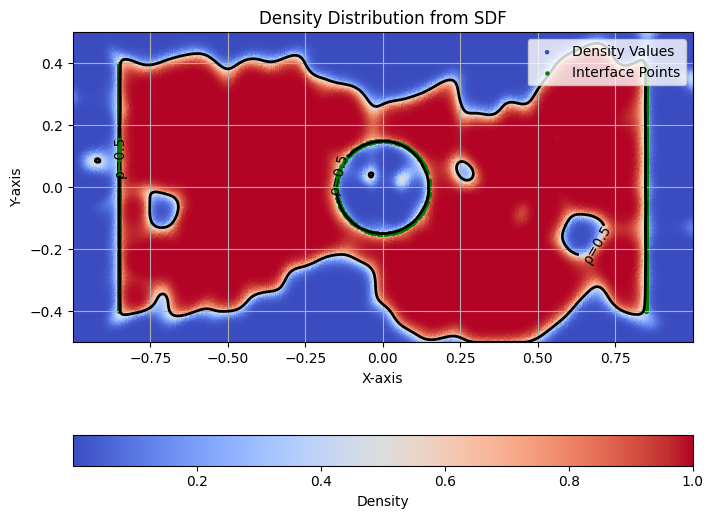

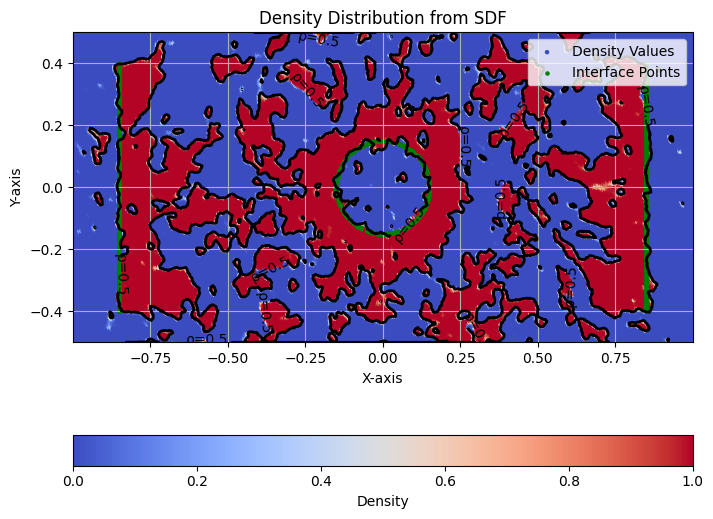

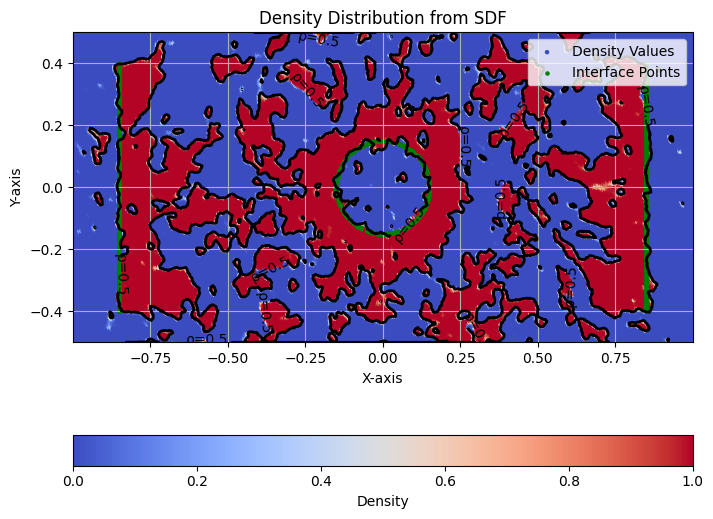

In [75]:
plot_GINN_geometry(BRIDGE,100000,GINN_model_holes) 

plot_GINN_geometry(BRIDGE,100000,GINN_model_fragments) 

In [ ]:
import numpy as np
import torch
import cripser

class PHManagerSingle:
    """PH manager derived from: https://github.com/ml-jku/GINNs-Geometry-informed-Neural-Networks/tree/main/GINN/ph """
    def __init__(self,
                 *,
                 nx: int,
                 bounds,                      
                 model: torch.nn.Module,
                 n_grid_points: int,
                 iso_level: float,
                 target_betti,
                 maxdim: int,
                 is_density: bool,
                 inside_envelope_fn=None,
                 group_size_fwd_no_grad: int = -1):

        super().__init__()
        self.nx     = int(nx)
        self.model  = model
        self.ISO    = float(iso_level)
        self.TARGET = list(target_betti)
        self.MAXDIM = int(maxdim)
        self.sign   = -1 if is_density else 1

        try:
            self.device = next(model.parameters()).device
        except StopIteration:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        b = torch.as_tensor(bounds, dtype=torch.float32, device=self.device)
        if b.ndim != 1:
            b = b.view(-1)
        assert b.numel() == 2 * self.nx, f"Expected flat bounds of length {2*self.nx}, got {b.numel()}."
        self.bounds = b.view(self.nx, 2)
        n = int(n_grid_points)
        mins = self.bounds[:, 0].detach().cpu().numpy()
        maxs = self.bounds[:, 1].detach().cpu().numpy()
        axes = [np.linspace(mins[i], maxs[i], n) for i in range(self.nx)]
        mg   = np.meshgrid(*axes, indexing='ij')
        xs   = np.vstack([g.ravel() for g in mg]).T  
        self.xs_flat = torch.tensor(xs, dtype=torch.float32, device=self.device)
        self.xs      = self.xs_flat.view(*(n,)*self.nx, self.nx) 
        if inside_envelope_fn is None:
            mask = torch.ones(self.xs_flat.shape[0], dtype=torch.bool, device=self.device)
            for i in range(self.nx):
                lo = self.bounds[i, 0]; hi = self.bounds[i, 1]
                mask &= (self.xs_flat[:, i] >= lo) & (self.xs_flat[:, i] <= hi)
        else:
            m = inside_envelope_fn(self.xs_flat)
            if isinstance(m, np.ndarray):
                m = torch.from_numpy(m)
            mask = m.to(device=self.device, dtype=torch.bool).view(-1)
        self.mask_in_flat = mask
        self.mask_in_grid = mask.view(self.xs.shape[:-1])     
        self.xs_in        = self.xs[self.mask_in_grid]        

        self.Y_inf = torch.full(self.mask_in_grid.shape, float('inf'), device=self.device)

        self.group_size = int(group_size_fwd_no_grad) if group_size_fwd_no_grad is not None else -1
        self._cache = {"fp": None, "PH": None, "Y": None}

    # --------------------- public API ---------------------

    def connectedness_loss(self) -> torch.Tensor:
        PH, _ = self.get_PH()
        device = self.device
        PH0 = PH[PH[:, 0] == 0]
        if PH0.size == 0:
            return torch.tensor(0.0, device=device)
        lengths = PH0[:, 2] - PH0[:, 1]
        order = np.argsort(lengths)[::-1]
        PH0 = PH0[order]
        sel = (PH0[:, 1] < -self.ISO) & (PH0[:, 2] > self.ISO)
        PH_sel = PH0[sel]

        deaths = PH_sel[:, 6:6 + self.nx].astype(int)
        tgt = self.TARGET[0] if len(self.TARGET) > 0 else 1
        deaths = deaths[tgt:]
        if deaths.size == 0:
            return torch.tensor(0.0, device=device)

        x_idcs = torch.from_numpy(deaths).to(device=device, dtype=torch.long)  # [k,nx]
        x_in   = self.xs[*x_idcs.T].reshape(-1, self.nx).to(device)

        with torch.no_grad():
            Yg = self.model(x_in).reshape(-1)
        loss = self.sign * torch.clamp(self.ISO - Yg, max=0.0).pow(2).sum()
        return loss

    def holes_loss(self) -> torch.Tensor:
        if self.MAXDIM < 1:
            return torch.tensor(0.0, device=self.device)

        PH, _ = self.get_PH()
        device = self.device

        PH1 = PH[PH[:, 0] == 1]
        if PH1.size == 0:
            return torch.tensor(0.0, device=device)

        lengths = PH1[:, 2] - PH1[:, 1]
        order = np.argsort(lengths)[::-1]
        PH1 = PH1[order]


        fin = PH1[:, 2] < 1.0e100
        PH1_fin = PH1[fin]
        start = self.TARGET[1] if len(self.TARGET) > 1 else 0
        PH1_fin = PH1_fin[start:]
        sel = (PH1_fin[:, 1] < -self.ISO) & (PH1_fin[:, 2] > self.ISO)
        PH_sel = PH1_fin[sel]
        deaths = PH_sel[:, 6:6 + self.nx].astype(int)
        if deaths.size == 0:
            return torch.tensor(0.0, device=device)

        x_idcs = torch.from_numpy(deaths).to(device=device, dtype=torch.long)
        x_in   = self.xs[*x_idcs.T].reshape(-1, self.nx).to(device)

        with torch.no_grad():
            Yg = self.model(x_in).reshape(-1)
        loss = self.sign * torch.clamp(self.ISO - Yg, max=0.0).pow(2).sum()
        return loss

    def invalidate_cache(self):
        self._cache = {"fp": None, "PH": None, "Y": None}


    def get_PH(self):
        s = 0.0; n = 0
        for p in self.model.parameters():
            if p.requires_grad and p.numel() > 0:
                s += float(p.detach().sum().item()); n += p.numel()
        fp = (n, round(s, 6))

        if self._cache["fp"] == fp and self._cache["PH"] is not None:
            return self._cache["PH"], self._cache["Y"]

        xs_in_flat = self.xs_in.reshape(-1, self.nx)            
        if self.group_size is None or self.group_size < 0 or xs_in_flat.shape[0] <= self.group_size:
            Y_in = self.model(xs_in_flat).reshape(-1)
        else:
            outs = []
            for i in range(0, xs_in_flat.shape[0], self.group_size):
                outs.append(self.model(xs_in_flat[i:i+self.group_size]).reshape(-1))
            Y_in = torch.cat(outs, dim=0)

        Y_full = self.Y_inf.clone()                            
        Y_full.view(-1)[self.mask_in_flat] = Y_in               

        Y_np = Y_full.detach().cpu().numpy()
        PH   = cripser.computePH(Y_np, maxdim=self.MAXDIM)

        self._cache = {"fp": fp, "PH": PH, "Y": Y_full}
        return PH, Y_full

In [ ]:
phm = PHManagerSingle(
    nx=BRIDGE.dim,                     
    bounds=BRIDGE.domain,              
    model=GINN_model_fragments,
    n_grid_points=128,                
    iso_level=0.0,                     
    target_betti=[1, 0, 0],            
    maxdim=1,                          
    is_density=False,                  
    inside_envelope_fn=None,           
    group_size_fwd_no_grad=32768       
)

loss_conn  = phm.connectedness_loss()
loss_holes = phm.holes_loss() 


## NOTE:
- Potentially need to fix the "inside_envelope_fn(x)" part of the code to be adaptable to various test cases - made spesifically for bridge rn
- Simplyfy as much as possible once we know it works!

In [92]:
print("holes:",loss_holes.item())
print("connectivity:",loss_conn.item()) 

holes: 0.5815736651420593
connectivity: 0.554601788520813


## Plotting

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_density_with_ph_clean(
    mgr,
    *,
    k_logistic: float = 100.0,     # density = 1/(1+exp(k*SDF)) 
    figsize=(10, 6),
    cmap='coolwarm'
):
    """
    Visualize density from mgr (PHManagerSingle) and overlay ONLY:
      - Fragments (extra b0 components)
      - Holes (extra b1 features)
    """
    assert mgr.nx == 2, "This function is for 2D problems (nx==2)."

    # get PH & field 
    if hasattr(mgr, "get_PH"):
        PH, Y_t = mgr.get_PH()
    elif hasattr(mgr, "_get_PH"):
        PH, Y_t = mgr._get_PH()
    else:
        raise AttributeError("Manager must expose get_PH() or _get_PH().")

    # convert to numpy
    Y = Y_t.detach().cpu().numpy()
    n0, n1 = Y.shape

    # axes from bounds
    b = mgr.bounds.detach().cpu().numpy()  
    x_axis = np.linspace(b[0, 0], b[0, 1], n0)
    y_axis = np.linspace(b[1, 0], b[1, 1], n1)

    # density from SDF 
    rho = 1.0 / (1.0 + np.exp(k_logistic * Y))


    def _filter_iso(phd, lengths, iso):
        sel = (phd[:, 1] < -iso) & (phd[:, 2] >  iso)
        return phd[sel], lengths[sel]

    def _filter_finite_death(phd, lengths):
        sel = (phd[:, 2] < 1.0e100)
        return phd[sel], lengths[sel]

    PH0 = PH[PH[:, 0] == 0]
    frag_xy = np.empty((0, 2), dtype=float)
    if PH0.size > 0:
        lengths0 = PH0[:, 2] - PH0[:, 1]
        order0 = np.argsort(lengths0)[::-1]
        PH0 = PH0[order0]; lengths0 = lengths0[order0]
        PH0_sel, _ = _filter_iso(PH0, lengths0, mgr.ISO)
        deaths0 = PH0_sel[:, 6:6 + mgr.nx].astype(int)
        tgt0 = mgr.TARGET[0] if len(mgr.TARGET) > 0 else 1
        deaths0 = deaths0[tgt0:]  # keep only extras beyond the target
        if deaths0.size > 0:
            frag_xy = np.column_stack([x_axis[deaths0[:, 0]], y_axis[deaths0[:, 1]]])

    # Extras for H1 (holes)
    hole_xy = np.empty((0, 2), dtype=float)
    if mgr.MAXDIM >= 1:
        PH1 = PH[PH[:, 0] == 1]
        if PH1.size > 0:
            lengths1 = PH1[:, 2] - PH1[:, 1]
            order1 = np.argsort(lengths1)[::-1]
            PH1 = PH1[order1]; lengths1 = lengths1[order1]
            PH1_fin, len_fin = _filter_finite_death(PH1, lengths1)
            start = mgr.TARGET[1] if len(mgr.TARGET) > 1 else 0
            PH1_sel, _ = _filter_iso(PH1_fin[start:], len_fin[start:], mgr.ISO)
            deaths1 = PH1_sel[:, 6:6 + mgr.nx].astype(int)
            if deaths1.size > 0:
                hole_xy = np.column_stack([x_axis[deaths1[:, 0]], y_axis[deaths1[:, 1]]])


    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 1, height_ratios=[18, 1], hspace=0.25)
    ax = fig.add_subplot(gs[0, 0])
    cax = fig.add_subplot(gs[1, 0])

 
    im = ax.imshow(
        rho.T,  
        origin='lower',
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        cmap=cmap,
        interpolation='bilinear',
        vmin=0.0, vmax=1.0
    )
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label('Density')

    ax.contour(
        x_axis, y_axis, rho.T,
        levels=[0.5],
        colors='k',
        linewidths=2.0,
        linestyles='-'
    )

    dx = (x_axis.max() - x_axis.min()) / max(n0 - 1, 1)
    dy = (y_axis.max() - y_axis.min()) / max(n1 - 1, 1)
    r = 1.25 * max(dx, dy)

    handles, labels = [], []

    if frag_xy.size > 0:
        h_frag = ax.scatter(
            frag_xy[:, 0], frag_xy[:, 1],
            s=160, marker='X',
            facecolor='#ff36ff', edgecolor='white', linewidth=1.6, zorder=6
        )
        for x, y in frag_xy:
            ax.add_patch(Circle(
                (x, y), r,
                fill=False, linewidth=2.5, edgecolor='#ff36ff', alpha=0.95, zorder=5
            ))
        handles.append(h_frag); labels.append("Fragments")

    # Holes: yellow dot with black edge + yellow ring 
    if hole_xy.size > 0:
        h_holes = ax.scatter(
            hole_xy[:, 0], hole_xy[:, 1],
            s=200, marker='o',
            facecolor='#ffd400', edgecolor='black', linewidth=2.2, zorder=7
        )
        for x, y in hole_xy:
            ax.add_patch(Circle(
                (x, y), r,
                fill=False, linewidth=2.5, edgecolor='#ffd400', alpha=0.95, zorder=6
            ))
        handles.append(h_holes); labels.append("Holes")

    if handles:
        ax.legend(handles, labels, loc='upper right', frameon=True)


    ax.set_title('Density Distribution from SDF (with PH overlay)')
    ax.set_xlabel('X-axis'); ax.set_ylabel('Y-axis')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.25)

    plt.show()
    return fig

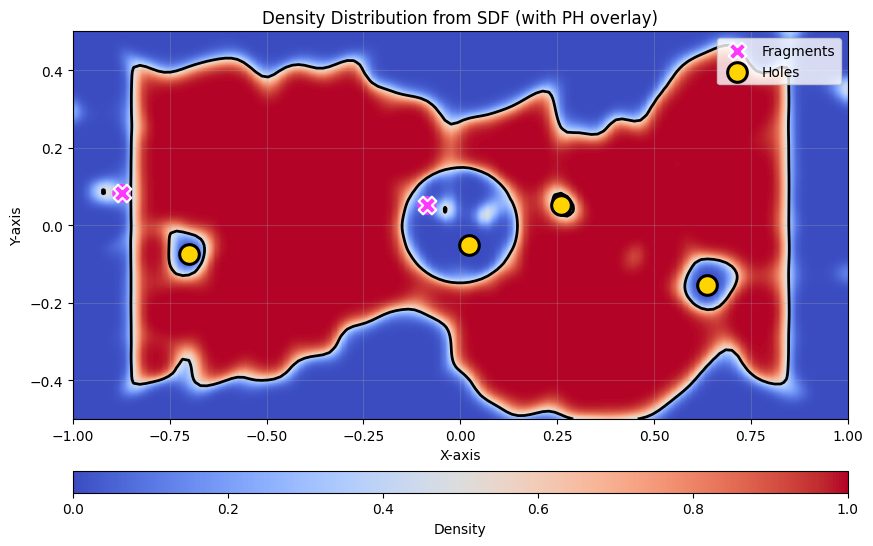

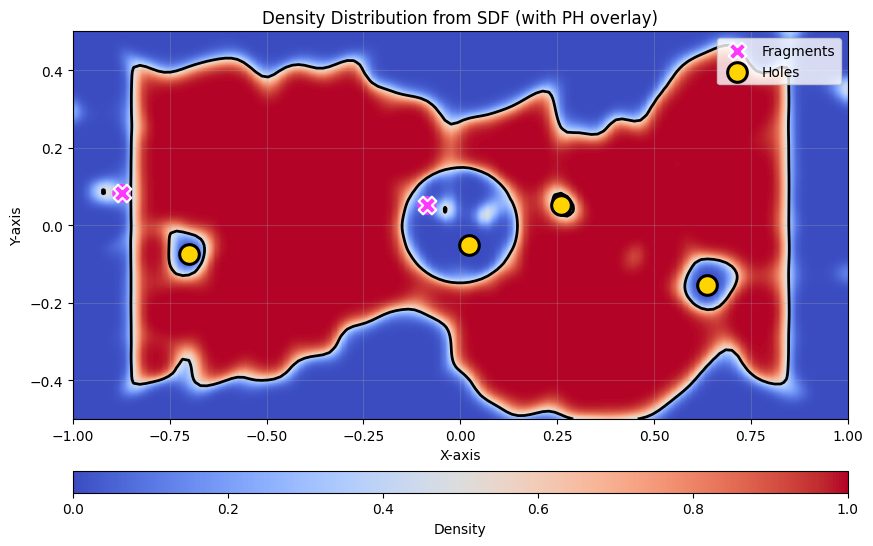

In [ ]:
phm = PHManagerSingle(
    nx=2,
    bounds=BRIDGE.domain,           
    model=GINN_model_holes,                 
    n_grid_points=128,                
    iso_level=0.0,
    target_betti=(1, 0),               
    maxdim=1,
    is_density=False                   
)

# plot + overlay
plot_density_with_ph_clean(phm)